In [1]:
import sys
import random
import numpy as np

try:
    from IPython.display import display
    from graphviz import Digraph
    import graphviz
    has_graphviz = True
except:
    has_graphviz = False

from mdp import MDP

In [2]:
# Taken from https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py
class FrozenLakeEnv(MDP):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    """

    MAPS = {
        "4x4": [
            "SFFF",
            "FHFH",
            "FFFH",
            "HFFG"
        ],
        "8x8": [
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG"
        ],
    }

    def __init__(self, desc=None, map_name="4x4", slip_chance=0.2):
        if desc is None and map_name is None:
            raise ValueError('Must provide either desc or map_name')
        elif desc is None:
            desc = self.MAPS[map_name]
        assert ''.join(desc).count(
            'S') == 1, "this implementation supports having exactly one initial state"
        assert all(c in "SFHG" for c in
                   ''.join(desc)), "all cells must be either of S, F, H or G"

        self.desc = desc = np.asarray(list(map(list, desc)), dtype='str')
        self.lastaction = None

        nrow, ncol = desc.shape
        states = [(i, j) for i in range(nrow) for j in range(ncol)]
        actions = ["left", "down", "right", "up"]

        initial_state = states[np.array(desc == b'S').ravel().argmax()]

        def move(row, col, movement):
            if movement == 'left':
                col = max(col - 1, 0)
            elif movement == 'down':
                row = min(row + 1, nrow - 1)
            elif movement == 'right':
                col = min(col + 1, ncol - 1)
            elif movement == 'up':
                row = max(row - 1, 0)
            else:
                raise ("invalid action")
            return (row, col)

        transition_probs = {s: {} for s in states}
        rewards = {s: {} for s in states}
        for (row, col) in states:
            if desc[row, col] in "GH": continue
            for action_i in range(len(actions)):
                action = actions[action_i]
                transition_probs[(row, col)][action] = {}
                rewards[(row, col)][action] = {}
                for movement_i in [(action_i - 1) % len(actions), action_i,
                                   (action_i + 1) % len(actions)]:
                    movement = actions[movement_i]
                    newrow, newcol = move(row, col, movement)
                    prob = (1. - slip_chance) if movement == action else (
                            slip_chance / 2.)
                    if prob == 0: continue
                    if (newrow, newcol) not in transition_probs[row, col][
                        action]:
                        transition_probs[row, col][action][
                            newrow, newcol] = prob
                    else:
                        transition_probs[row, col][action][
                            newrow, newcol] += prob
                    if desc[newrow, newcol] == 'G':
                        rewards[row, col][action][newrow, newcol] = 1.0

        MDP.__init__(self, transition_probs, rewards, initial_state)

    def render(self):
        desc_copy = np.copy(self.desc)
        desc_copy[self._current_state] = '*'
        print('\n'.join(map(''.join, desc_copy)), end='\n\n')

In [3]:
def plot_graph(mdp, graph_size='10,10', s_node_size='1,5',
               a_node_size='0,5', rankdir='LR', ):
    """
    Function for pretty drawing MDP graph with graphviz library.
    Requirements:
    graphviz : https://www.graphviz.org/
    for ubuntu users: sudo apt-get install graphviz
    python library for graphviz
    for pip users: pip install graphviz
    :param mdp:
    :param graph_size: size of graph plot
    :param s_node_size: size of state nodes
    :param a_node_size: size of action nodes
    :param rankdir: order for drawing
    :return: dot object
    """
    s_node_attrs = {'shape': 'doublecircle',
                    'color': 'lightgreen',
                    'style': 'filled',
                    'width': str(s_node_size),
                    'height': str(s_node_size),
                    'fontname': 'Arial',
                    'fontsize': '24'}

    a_node_attrs = {'shape': 'circle',
                    'color': 'lightpink',
                    'style': 'filled',
                    'width': str(a_node_size),
                    'height': str(a_node_size),
                    'fontname': 'Arial',
                    'fontsize': '20'}

    s_a_edge_attrs = {'style': 'bold',
                      'color': 'red',
                      'ratio': 'auto'}

    a_s_edge_attrs = {'style': 'dashed',
                      'color': 'blue',
                      'ratio': 'auto',
                      'fontname': 'Arial',
                      'fontsize': '16'}

    graph = Digraph(name='MDP')
    graph.attr(rankdir=rankdir, size=graph_size)
    for state_node in mdp._transition_probs:
        graph.node(state_node, **s_node_attrs)

        for posible_action in mdp.get_possible_actions(state_node):
            action_node = state_node + "-" + posible_action
            graph.node(action_node,
                       label=str(posible_action),
                       **a_node_attrs)
            graph.edge(state_node, state_node + "-" +
                       posible_action, **s_a_edge_attrs)

            for posible_next_state in mdp.get_next_states(state_node,
                                                          posible_action):
                probability = mdp.get_transition_prob(
                    state_node, posible_action, posible_next_state)
                reward = mdp.get_reward(
                    state_node, posible_action, posible_next_state)

                if reward != 0:
                    label_a_s_edge = 'p = ' + str(probability) + \
                                     '  ' + 'reward =' + str(reward)
                else:
                    label_a_s_edge = 'p = ' + str(probability)

                graph.edge(action_node, posible_next_state,
                           label=label_a_s_edge, **a_s_edge_attrs)
    return graph

In [4]:
def plot_graph_with_state_values(mdp, state_values):
    graph = plot_graph(mdp)
    for state_node in mdp._transition_probs:
        value = state_values[state_node]
        graph.node(state_node,
                   label=str(state_node) + '\n' + 'V =' + str(value)[:4])
    return display(graph)

In [5]:
def get_optimal_action_for_plot(mdp, state_values, state, gamma=0.9):
    if mdp.is_terminal(state): return None
    next_actions = mdp.get_possible_actions(state)
    q_values = [get_action_value(mdp, state_values, state, action, gamma) for
                action in next_actions]
    optimal_action = next_actions[np.argmax(q_values)]
    return optimal_action

In [6]:
def plot_graph_optimal_strategy_and_state_values(mdp, state_values):
    graph = plot_graph(mdp)
    opt_s_a_edge_attrs = {'style': 'bold',
                          'color': 'green',
                          'ratio': 'auto',
                          'penwidth': '6'}

    for state_node in mdp._transition_probs:
        value = state_values[state_node]
        graph.node(state_node,
                   label=str(state_node) + '\n' + 'V =' + str(value)[:4])
        for action in mdp.get_possible_actions(state_node):
            if action == get_optimal_action_for_plot(mdp,
                                                     state_values,
                                                     state_node,
                                                     gamma):
                graph.edge(state_node, state_node + "-" + action,
                           **opt_s_a_edge_attrs)
    return display(graph)

In [7]:
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [8]:
def get_new_state_value(mdp, state_values, state, gamma):
    if mdp.is_terminal(state): return 0
    v = 0
    for action in mdp.get_possible_actions(state):
        v = max(get_action_value(mdp, state_values, state, action, gamma), v)
    return  v

def get_action_value(mdp, state_values, state, action, gamma):
    Q = 0
    for next_state in mdp.get_all_states():
        probabs = mdp.get_transition_prob(state, action, next_state)
        reward_term = mdp.get_reward(state, action, next_state) + gamma * state_values[next_state]
        Q += probabs * reward_term
    return Q

def get_optimal_action(mdp, state_values, state, gamma=0.9):
    if mdp.is_terminal(state): return None
    actions = mdp.get_possible_actions(state)
    final_action_value = {action:get_action_value(mdp, state_values, state, action, gamma) for action in actions}
    optimal_action = sorted(final_action_value, key=lambda x:final_action_value[x], reverse=True)[0]
    return optimal_action


def value_iteration(mdp, state_values=None, gamma = 0.9, num_iter = 1000, min_difference = 1e-5):
    state_values = state_values or {s : 0 for s in mdp.get_all_states()}
    for i in range(num_iter):
        new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) for state in state_values.keys()}
        diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f "%(i, diff, new_state_values[mdp._initial_state]))
        state_values = new_state_values
        if diff < min_difference:
            print("Terminated"); break
    return state_values

In [9]:
state_values = value_iteration(mdp)

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 
Terminated


In [10]:
gamma = 0.9
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done: break

*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw_policy(mdp, state_values):
    plt.figure(figsize=(3,3))
    h,w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w,h), cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down':(0, -1), 'right':(1,0), 'up':(-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y,x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None: continue
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
    plt.grid(color='b', lw=2, ls='-')
    plt.show()


after iteration 0
iter    0   |   diff: 1.00000   |   V(start): 0.000 


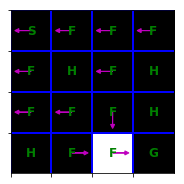

after iteration 1
iter    0   |   diff: 0.90000   |   V(start): 0.000 


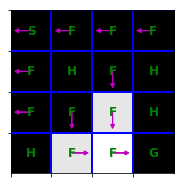

after iteration 2
iter    0   |   diff: 0.81000   |   V(start): 0.000 


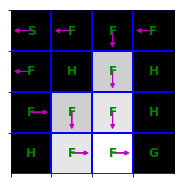

after iteration 3
iter    0   |   diff: 0.72900   |   V(start): 0.000 


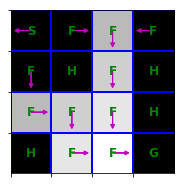

after iteration 4
iter    0   |   diff: 0.65610   |   V(start): 0.000 


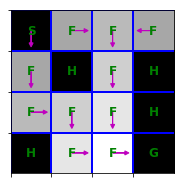

after iteration 5
iter    0   |   diff: 0.59049   |   V(start): 0.590 


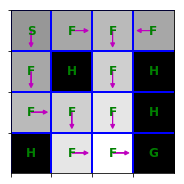

after iteration 6
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated


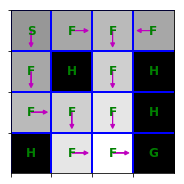

after iteration 7
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated


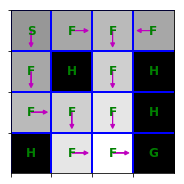

after iteration 8
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated


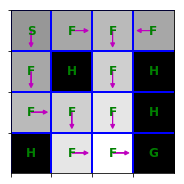

after iteration 9
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated


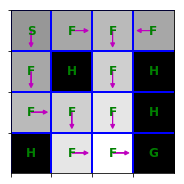

In [12]:
state_values = {s : 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i"%i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)